In [146]:
import ids_peak.ids_peak as ids_peak
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import ids_peak.ids_peak_ipl_extension as ids_ipl_extension
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt


ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
device_manager.Update()
device_descriptors = device_manager.Devices()

print("Found Devices: " + str(len(device_descriptors)))
for device_descriptor in device_descriptors:
    print(device_descriptor.DisplayName())


Found Devices: 1
IDS Imaging Development Systems GmbH U3-327xCP-M (1409f4e761f0U3-327xCP-M-0)


UTILIZAR CAMARA:

Para ejecutarla correctamente, se debe inicializar la libreria de ids_peak y crear una instancia del contorlador de dispositivos. Al actualizarle, se puede detectar la camara (si no está siendo utilizada por otra aplicación). 

A continuación, se abre la cámara y se establece el tipo de disparo ('software trigger').

Seguidamente, se puede iniciar la adquisición. Para lo cual se define el buffer y se activa la adquisición a la espera de triggers.

Se establece el tiempo de exposición.

Se toma una imagen, ejecutando el trigger, obtenienddola del buffer y transformandola en un formato color rgb. Esta se puede guardar.

Al acabar, se debe asegurar que los dispositivos estén cerrados. Para lo cual se cierra la librería ids_peak.

Open Device

In [147]:
device = device_descriptors[0].OpenDevice(ids_peak.DeviceAccessType_Control)
print("Opened Device: " + device.DisplayName())
remote_device_nodemap = device.RemoteDevice().NodeMaps()[0]

Opened Device: IDS Imaging Development Systems GmbH U3-327xCP-M (1409f4e761f0U3-327xCP-M-0)


Set software trigger

In [148]:
# Single frame acquisition
remote_device_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
remote_device_nodemap.FindNode("TriggerSource").SetCurrentEntry("Software")
remote_device_nodemap.FindNode("TriggerMode").SetCurrentEntry("On")

Start Image Acquisition

In [149]:
datastream = device.DataStreams()[0].OpenDataStream()
payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
for i in range(datastream.NumBuffersAnnouncedMinRequired()):
    buffer = datastream.AllocAndAnnounceBuffer(payload_size)
    datastream.QueueBuffer(buffer)
    
datastream.StartAcquisition()
remote_device_nodemap.FindNode("AcquisitionStart").Execute()
remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

Set exposure


In [150]:
exposure_time_seg = 1/250
exposure_time_microseg = exposure_time_seg * 1e6

remote_device_nodemap.FindNode("ExposureTime").SetValue(exposure_time_microseg) # in microseconds  

Grab 1 Image

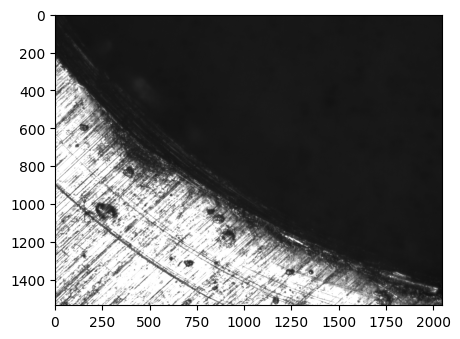

In [183]:
# trigger image
remote_device_nodemap.FindNode("TriggerSoftware").Execute()
buffer = datastream.WaitForFinishedBuffer(1000)

# convert to RGB
raw_image = ids_ipl_extension.BufferToImage(buffer)
# for Peak version 2.0.1 and lower, use this function instead of the previous line:
#raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_RGB8)
datastream.QueueBuffer(buffer)

picture = color_image.get_numpy_3D()

# display the image
plt.figure(figsize = (5,5))

plt.imshow(picture)



timestamp = dt.datetime.now()
file_name = f'img/tests/img_{timestamp.strftime("%Y%m%d_%H%M%S")}.png'
plt.savefig(file_name)

## Ajuste automático de la exposición

In [7]:
def GetRightExposedImage():
    return 0

import datetime as dt



timestamp = dt.datetime.now()
file_name = f'img/img_{timestamp.strftime("%Y%m%d_%H%M%S")}.png'

print(file_name)

img/img_20250228_121320.png


## Cerrar Camaras

In [188]:
ids_peak.Library.Close()

## Analizar Imagenes


Centro de masas: (121.39778714436248, 188.60115911485775)
(281, 385)
Centro de masas: (234.4119342750072, 77.66042087056789)
(281, 385)
Centro de masas: (280.46915322580645, 100.19354838709677)
(281, 385)
Centro de masas: (79.34111691704769, 83.84781188765513)
(281, 385)
Centro de masas: (218.9364088005678, 95.16905606813343)
(281, 385)


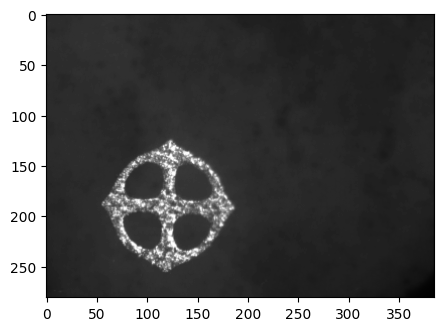

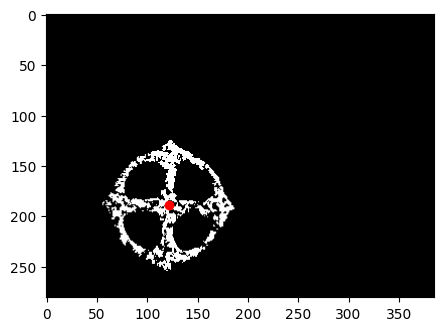

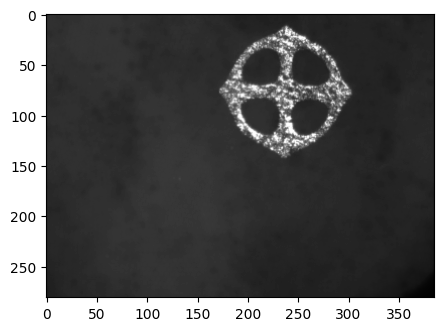

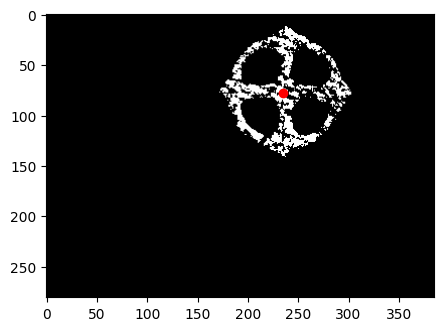

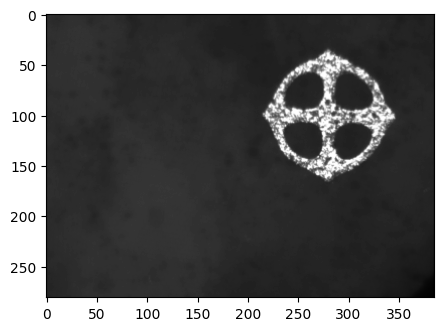

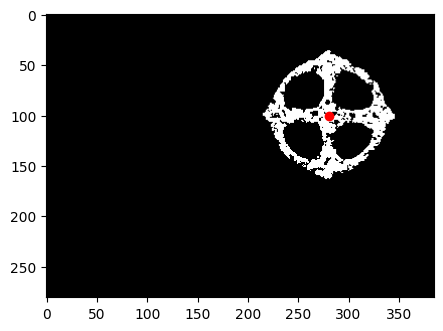

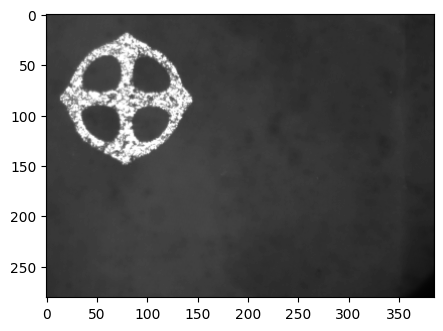

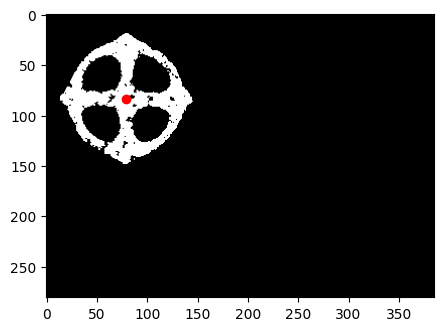

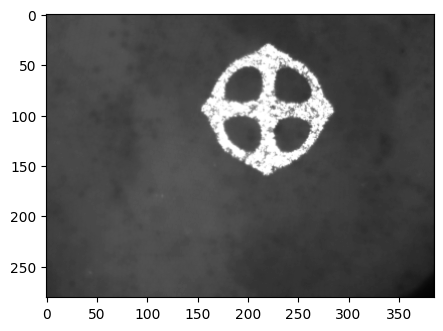

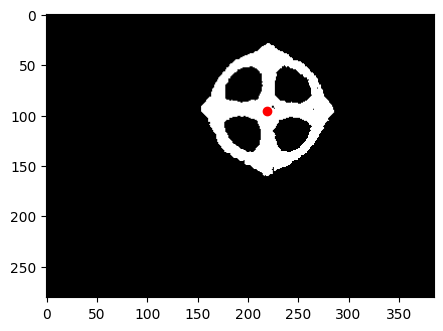

In [9]:
import cv2
# picture = cv2.imread('img/fiducial/')
# picture_roi = picture[120:380, 100:400, 0]

# print(picture_roi.max())

# plt.figure(figsize = (5,5))
# plt.imshow(picture_roi, cmap = 'gray')


    
# def get_roi(image):
    

def binarize(img):
    return np.where(img > img.max()/2, 255, 0)
    # adaptive_threshold_gaussian
    # return cv2.adaptiveThreshold(img, np.max(img), cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 6)


def soften(image, m = 8 ):
    # Average filter
    image2 = np.copy(image)

    for i in range(0+m, image.shape[0] - m):
        for j in range(0+m, image.shape[1] - m):
            image2[i,j] = np.mean(image[i-m:i+m, j-m:j+m])
    return image2


def find_cm(image):
    yy, xx = np.where(image == 255)
    return (xx.mean(), yy.mean()) if xx.size > 0 else (None, None)

def find_radius(image):
    #  fila: y, columna: x
    x_cm, y_cm = find_cm(image)
    line1 = image[:, int(x_cm)]
    line2 = image[:, int(x_cm)]
    cm = [x_cm, y_cm]
    for n, line in enumerate([line1, line2]):
        for i, point in enumerate(line):
            if point != 0:
                r = cm[n] - i
                break
    return np.mean(r)


from PIL import Image
import glob

image_list = []

for filename in glob.glob('img/fiducial/*.png'):
    # bucle para analizar varias imagenes

    picture = cv2.imread(filename)

    # picture_roi = picture[120:380, 100:400, 0]
    picture_roi = picture[109:390, 65:450, 0]

    plt.figure(figsize = (5,5))
    plt.imshow(picture_roi, cmap = 'gray')

    # picture_roi = soften(picture_roi, m = 8)
    plt.figure(figsize = (5,5))
    plt.imshow(picture_roi, cmap = 'gray')

    picture_binarized = binarize(picture_roi)
    cm = find_cm(picture_binarized)
    radius = find_radius(picture_binarized)
    print('Centro de masas:', cm)
    # print('Radio:', radius)
    circle = plt.Circle(cm, radius*1.2, color='b', fill=False)

    ax = plt.gca()
    ax.cla() # clear things for fresh plot

    print(picture_binarized.shape)
    ax.imshow(picture_binarized, cmap= 'gray')
    ax.plot(cm[0], cm[1], 'ro')
    # ax.add_patch(circle)

255


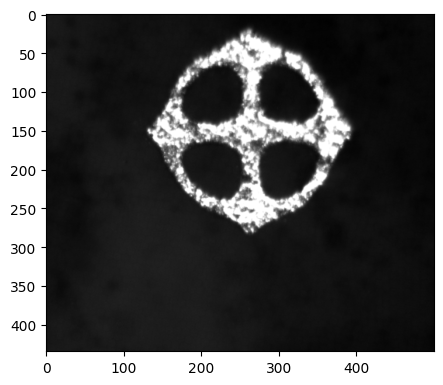

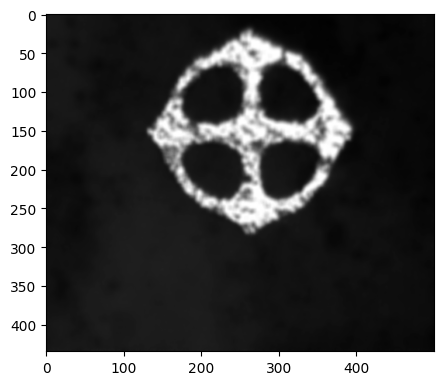

(264.4728441427127, 150.72165246280514)
(264.29284488064, 152.28656107278204)
(263.8249807459566, 152.85859280448895)
(264.4728441427127, 150.72165246280514)
(265.85370611183356, 150.41955313866887)
(264.7771841327642, 151.36331074829118)


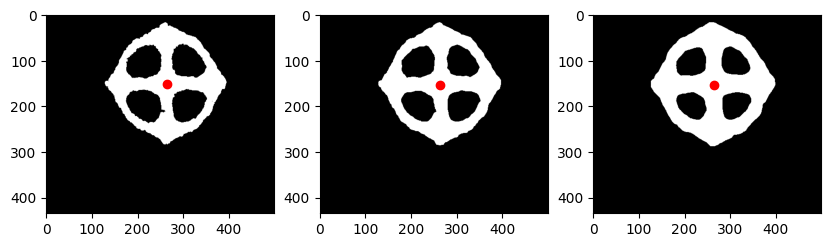

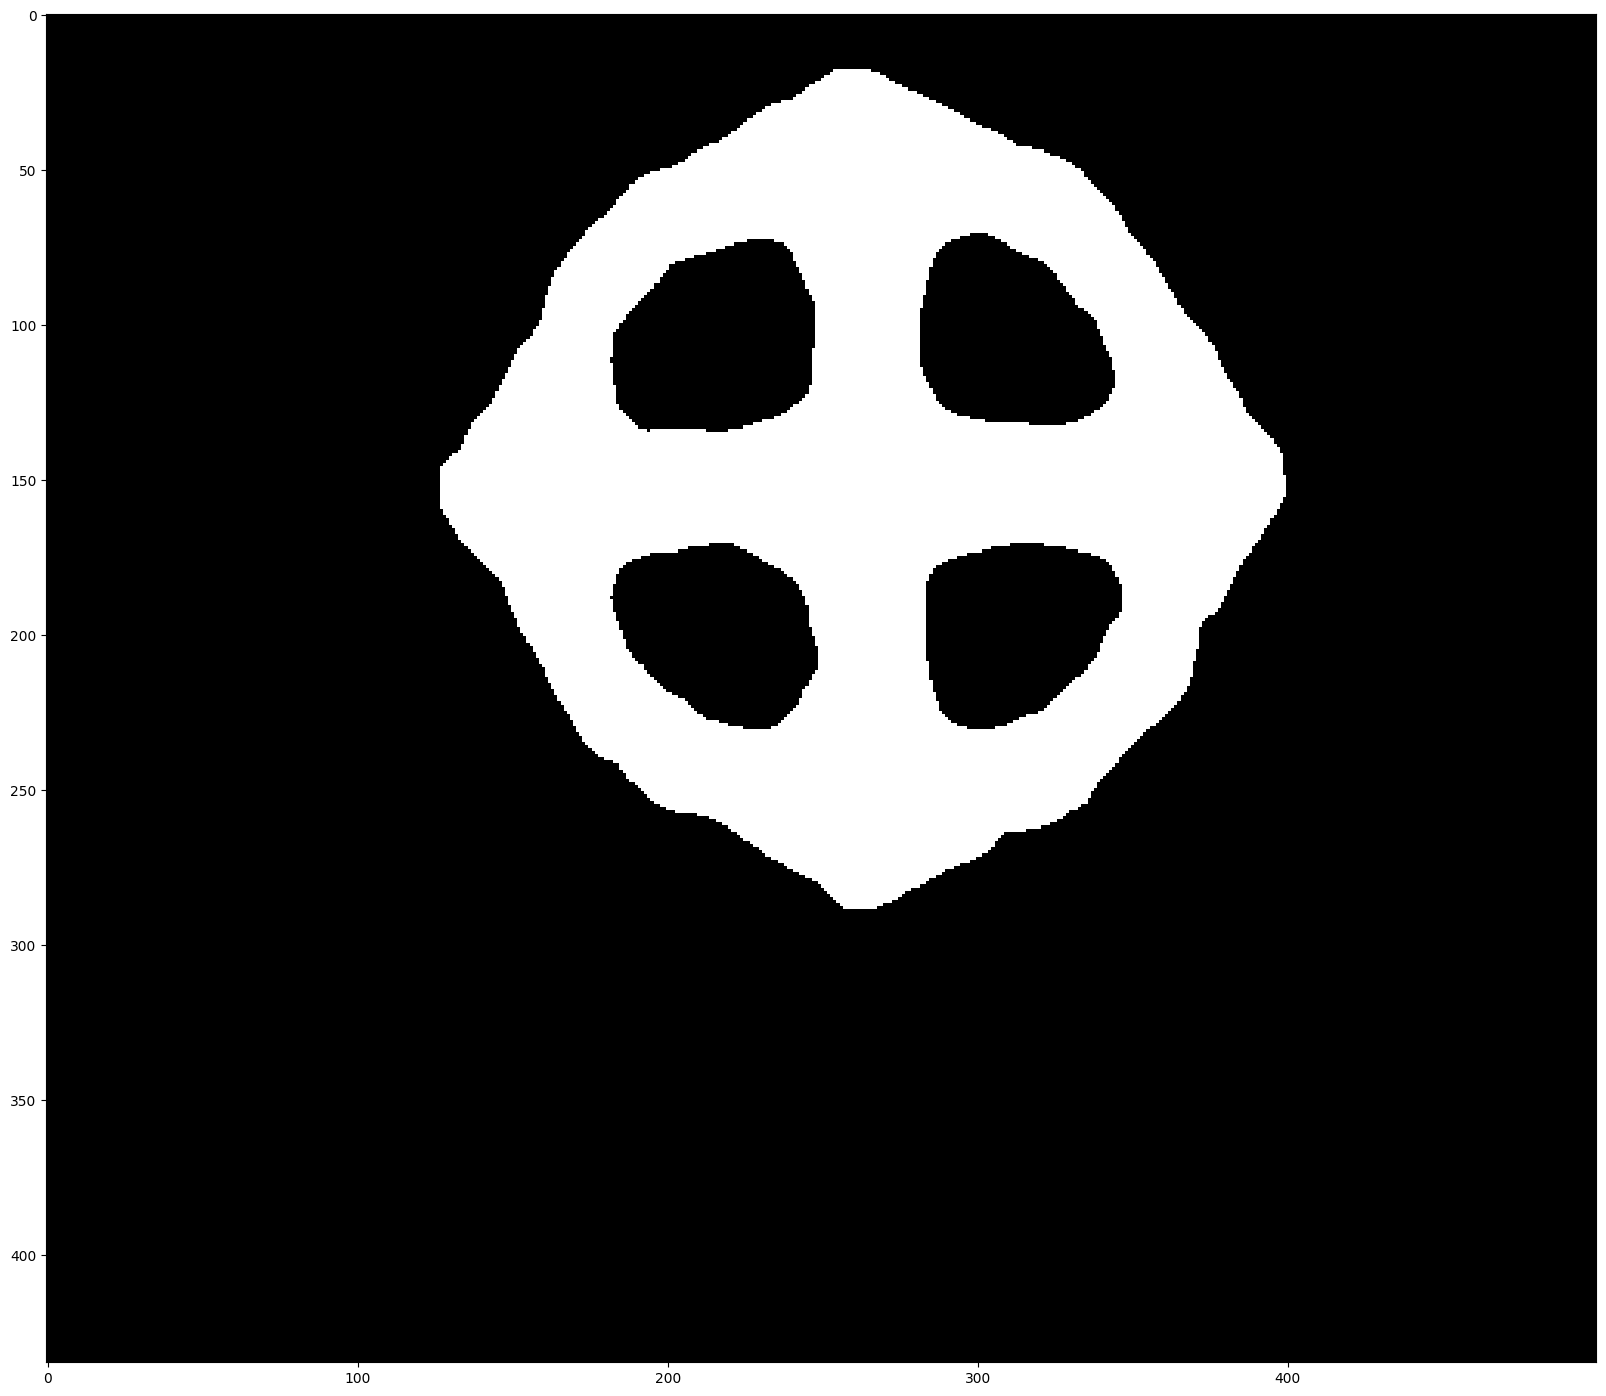

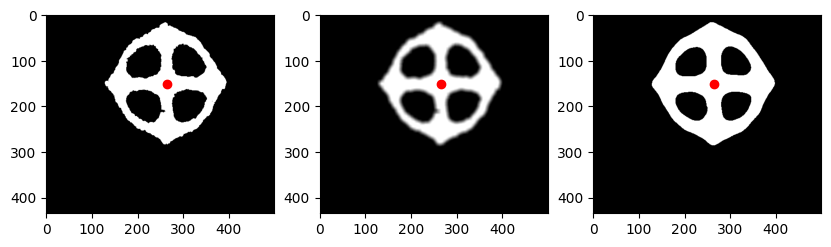

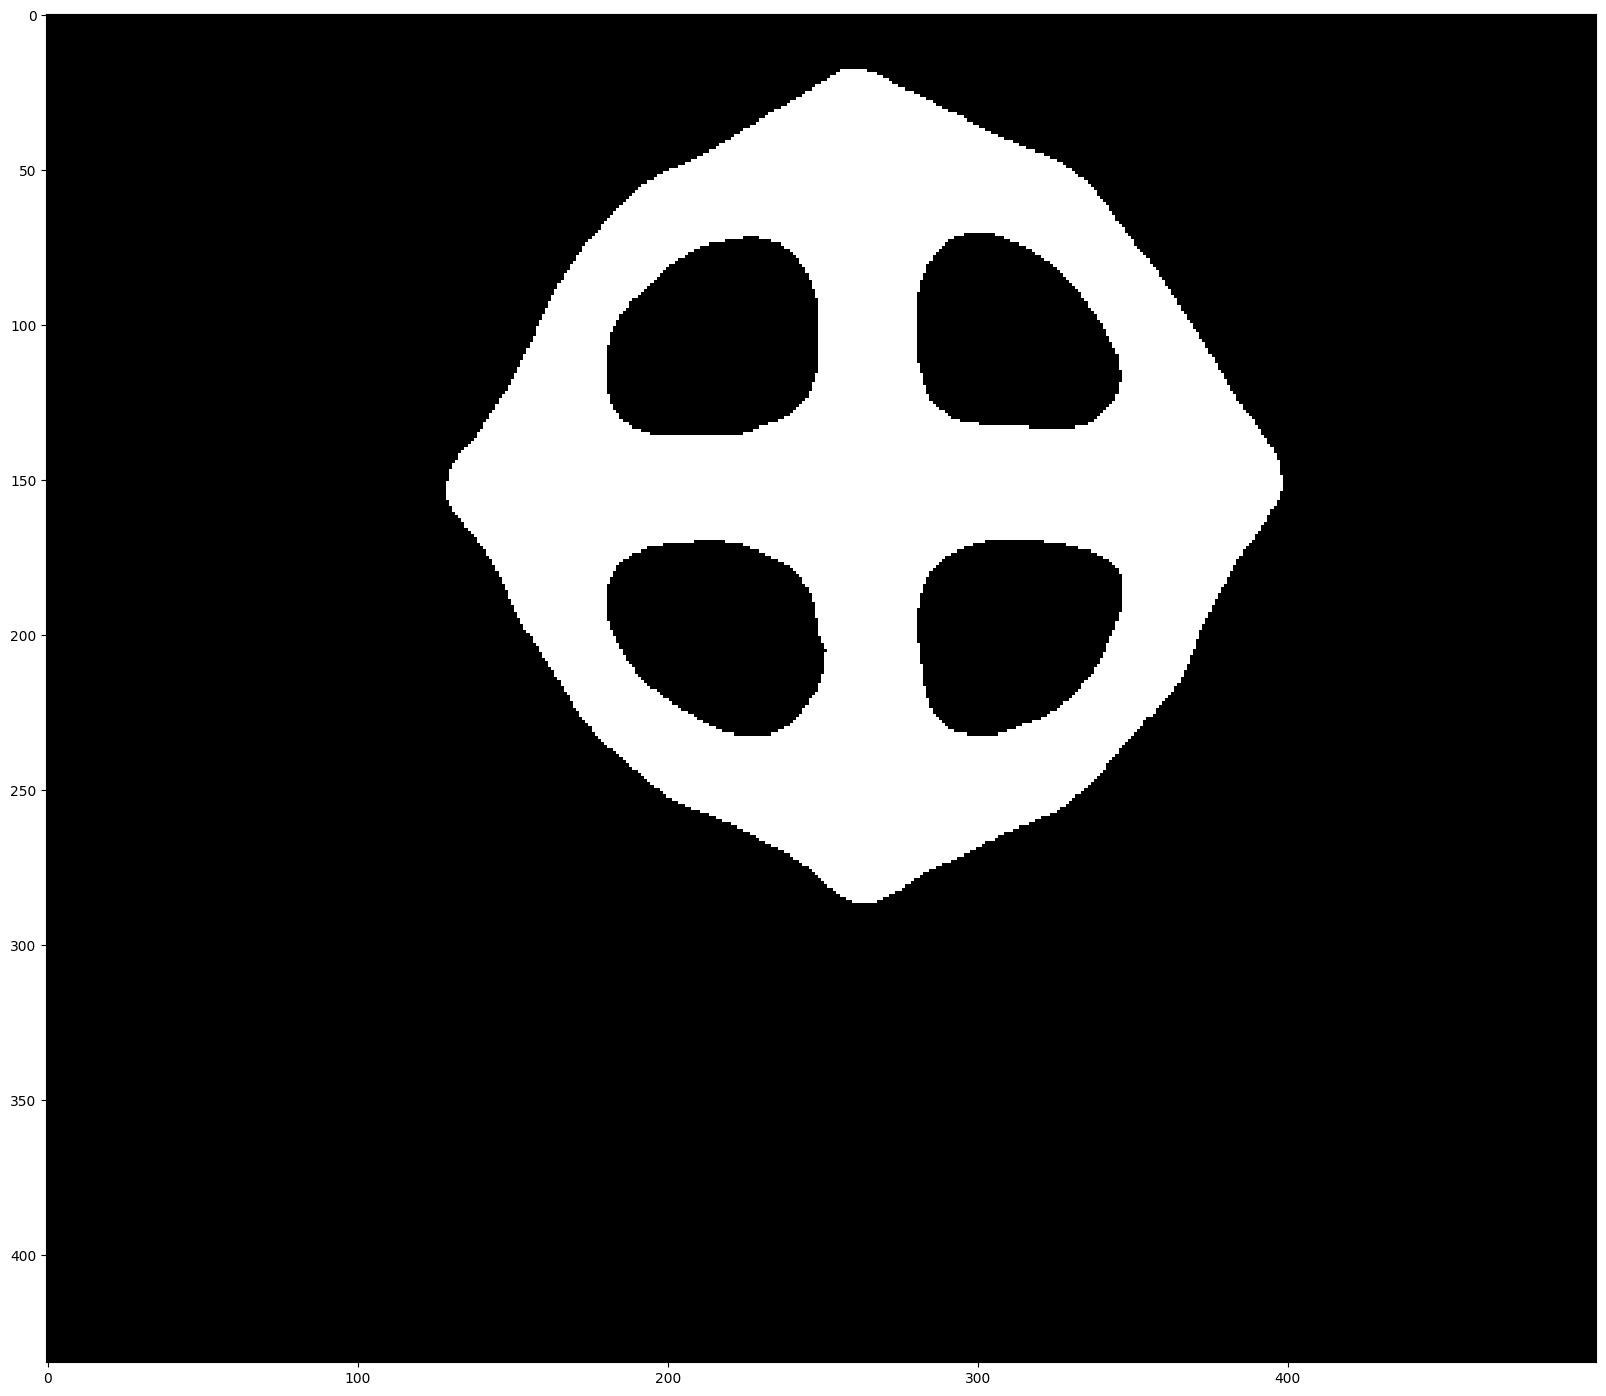

In [10]:
import cv2
from matplotlib.image import imread 
import matplotlib.pyplot as plt
import numpy as np

# La imagen está normalizada a 1?


picture = cv2.imread('img/img_20250210_121302.png')

picture_roi = picture[215:650, 250:750, 0]


print(picture_roi.max())

def binarize(image):
    return np.where(image > 80, 255, 0)

plt.figure(figsize = (5,5))
plt.imshow(picture_roi, cmap= 'gray')
plt.show()

def soften(image, m = 8 ):
    # Average filter
    image2 = np.copy(image)

    for i in range(0+m, image.shape[0] - m):
        for j in range(0+m, image.shape[1] - m):
            image2[i,j] = np.mean(image[i-m:i+m, j-m:j+m])
    return image2
plt.figure(figsize = (5,5))
plt.imshow(soften(picture_roi, 3), cmap= 'gray')
plt.show()


def find_cm(image):
    yy, xx = np.where(image == 255)
    return (xx.mean(), yy.mean()) if xx.size > 0 else (None, None)


picture_binarized = binarize(picture_roi)
cm = find_cm(picture_binarized)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(picture_binarized, cmap= 'gray')
plt.plot(cm[0], cm[1], 'ro')
print(cm)

picture_binarized = soften(picture_roi, 5)
picture_binarized = binarize(picture_binarized)
cm = find_cm(picture_binarized)
plt.subplot(1,3,2)
plt.imshow(picture_binarized, cmap= 'gray')
plt.plot(cm[0], cm[1], 'ro')
print(cm)


picture_binarized = soften(picture_roi, 10)
picture_binarized = binarize(picture_binarized)
cm = find_cm(picture_binarized)
plt.subplot(1,3,3)
plt.imshow(picture_binarized, cmap= 'gray')
plt.plot(cm[0], cm[1], 'ro')
print(cm)



plt.figure(figsize = (20,20))
plt.imshow(picture_binarized, cmap= 'gray')


# Soften despues del binarizado


picture_binarized = binarize(picture_roi)
cm = find_cm(picture_binarized)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(picture_binarized, cmap= 'gray')
plt.plot(cm[0], cm[1], 'ro')
print(cm)

picture_binarized = binarize(picture_roi)
picture_binarized = soften(picture_binarized, 5)
cm = find_cm(picture_binarized)
plt.subplot(1,3,2)
plt.imshow(picture_binarized, cmap= 'gray')
plt.plot(cm[0], cm[1], 'ro')
print(cm)


picture_binarized = binarize(picture_roi)
picture_binarized = soften(picture_binarized, 10)
picture_binarized = binarize(picture_binarized)
cm = find_cm(picture_binarized)
plt.subplot(1,3,3)
plt.imshow(picture_binarized, cmap= 'gray')
plt.plot(cm[0], cm[1], 'ro')
print(cm)



plt.figure(figsize = (20,20))
plt.imshow(picture_binarized, cmap= 'gray')


Manipular Imagen

Cerrar cámaras

In [11]:
ids_peak.Library.Close()